# Advanced Multi-Horizon LSTM (v2 - Full Data + MSE)

Improvements over v1:
1. **Full training data**: Use all samples (no limit per station)
2. **MSE loss**: Direct RMSE optimization instead of quantile loss
3. **Simpler output**: 1 value per horizon instead of 3 quantiles

## Target Metrics
| Horizon | Previous Best | Target |
|---------|---------------|--------|
| 1h | 0.647°C | ~0.65°C |
| 6h | 1.464°C | ~1.50°C |
| 12h | 2.151°C | ~2.20°C |
| 24h | 2.454°C | ~2.60°C |

In [17]:
# Imports
import os
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import json
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.cuda.amp import autocast, GradScaler

import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Setup project path
current_dir = Path(os.getcwd()).resolve()
if current_dir.name == '05_gnn_model':
    project_root = current_dir.parent.parent
elif current_dir.name == 'notebooks':
    project_root = current_dir.parent
else:
    for parent in current_dir.parents:
        if (parent / 'src').exists() and (parent / 'notebooks').exists():
            project_root = parent
            break
    else:
        project_root = current_dir

if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

from src.utils.config import PROCESSED_DATA_DIR, GRAPHS_DIR, RESULTS_DIR

print(f"Project root: {project_root}")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Project root: C:\Users\Kata\Desktop\earth-sgnn
Device: cuda
GPU: NVIDIA GeForce RTX 4070 Laptop GPU


## 1. Load Data

In [18]:
print("Loading data...")
df = pd.read_parquet(PROCESSED_DATA_DIR / "noaa_isd_preprocessed.parquet")
station_meta = pd.read_csv(PROCESSED_DATA_DIR / "station_metadata.csv")

with open(PROCESSED_DATA_DIR / "preprocessing_stats.json", 'r') as f:
    prep_stats = json.load(f)

print(f"Data: {len(df):,} observations")
print(f"Stations: {df['station_id'].nunique()}")

station_ids = station_meta['station_id'].values
station_to_idx = {sid: idx for idx, sid in enumerate(station_ids)}

TARGET_VAR = 'temperature_2m'
TARGET_VAR_NORM = 'temperature_2m_normalized'
target_mean = prep_stats['normalization'][TARGET_VAR]['mean']
target_std = prep_stats['normalization'][TARGET_VAR]['std']

FEATURE_COLS = [
    'temperature_2m_normalized',
    'dewpoint_2m_normalized',
    'relative_humidity_2m_normalized',
    'wind_u_normalized',
    'wind_v_normalized',
    'hour_sin', 'hour_cos',
    'doy_sin', 'doy_cos'
]
N_FEATURES = len(FEATURE_COLS)
print(f"Features: {N_FEATURES}")

Loading data...
Data: 9,326,949 observations
Stations: 822
Features: 9


In [19]:
df_train = df[df['split'] == 'train'].copy()
df_val = df[df['split'] == 'val'].copy()
df_test = df[df['split'] == 'test'].copy()

print(f"Train: {len(df_train):,}")
print(f"Val: {len(df_val):,}")
print(f"Test: {len(df_test):,}")

Train: 7,104,704
Val: 1,489,403
Test: 732,842


## 2. Fast Dataset Creation (Full Data)

In [20]:
def create_sequences_fast(df, station_to_idx, feature_cols, target_col, 
                          lookback=24, horizons=[1, 6, 12, 24], max_samples_per_station=None):
    """Fast vectorized sequence creation."""
    max_horizon = max(horizons)
    n_horizons = len(horizons)
    
    all_sequences = []
    all_targets = []
    all_masks = []
    
    station_groups = df.groupby('station_id')
    valid_stations = [s for s in station_groups.groups.keys() if s in station_to_idx]
    
    print(f"  Processing {len(valid_stations)} stations...")
    
    for station_id in tqdm(valid_stations, desc="  Stations"):
        group = station_groups.get_group(station_id).sort_values('timestamp')
        n_rows = len(group)
        
        if n_rows < lookback + max_horizon:
            continue
        
        features = group[feature_cols].values.astype(np.float32)
        targets = group[target_col].values.astype(np.float32)
        
        n_seqs = n_rows - lookback - max_horizon + 1
        
        if max_samples_per_station and n_seqs > max_samples_per_station:
            indices = np.sort(np.random.choice(n_seqs, max_samples_per_station, replace=False))
        else:
            indices = np.arange(n_seqs)
        
        for i in indices:
            seq = features[i:i+lookback]
            
            if np.isnan(seq).any():
                continue
            
            horizon_targets = np.zeros(n_horizons, dtype=np.float32)
            horizon_masks = np.zeros(n_horizons, dtype=np.float32)
            
            for h_idx, h in enumerate(horizons):
                tgt = targets[i + lookback + h - 1]
                if not np.isnan(tgt):
                    horizon_targets[h_idx] = tgt
                    horizon_masks[h_idx] = 1.0
            
            if horizon_masks.sum() > 0:
                all_sequences.append(seq)
                all_targets.append(horizon_targets)
                all_masks.append(horizon_masks)
    
    sequences = torch.tensor(np.stack(all_sequences), dtype=torch.float32)
    targets = torch.tensor(np.stack(all_targets), dtype=torch.float32)
    masks = torch.tensor(np.stack(all_masks), dtype=torch.float32)
    
    print(f"  Created {len(sequences):,} samples")
    return sequences, targets, masks

In [21]:
# Configuration - USE ALL DATA
LOOKBACK = 24
HORIZONS = [1, 6, 12, 24]
BATCH_SIZE = 1024
EPOCHS = 20

# CHANGE: Use all data (None = no limit)
MAX_SAMPLES_PER_STATION = None

print(f"Configuration:")
print(f"  Lookback: {LOOKBACK}")
print(f"  Horizons: {HORIZONS}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Epochs: {EPOCHS}")
print(f"  Max samples per station: {MAX_SAMPLES_PER_STATION} (all data)")

Configuration:
  Lookback: 24
  Horizons: [1, 6, 12, 24]
  Batch size: 1024
  Epochs: 20
  Max samples per station: None (all data)


In [22]:
%%time
print("Creating training sequences (full data)...")
train_seqs, train_targets, train_masks = create_sequences_fast(
    df_train, station_to_idx, FEATURE_COLS, TARGET_VAR_NORM,
    lookback=LOOKBACK, horizons=HORIZONS, max_samples_per_station=MAX_SAMPLES_PER_STATION
)

print("\nCreating validation sequences...")
val_seqs, val_targets, val_masks = create_sequences_fast(
    df_val, station_to_idx, FEATURE_COLS, TARGET_VAR_NORM,
    lookback=LOOKBACK, horizons=HORIZONS, max_samples_per_station=None
)

print("\nCreating test sequences...")
test_seqs, test_targets, test_masks = create_sequences_fast(
    df_test, station_to_idx, FEATURE_COLS, TARGET_VAR_NORM,
    lookback=LOOKBACK, horizons=HORIZONS, max_samples_per_station=None
)

Creating training sequences (full data)...
  Processing 822 stations...


  Stations: 100%|██████████| 822/822 [01:04<00:00, 12.77it/s]


  Created 4,302,686 samples

Creating validation sequences...
  Processing 820 stations...


  Stations: 100%|██████████| 820/820 [00:29<00:00, 28.00it/s]


  Created 936,453 samples

Creating test sequences...
  Processing 812 stations...


  Stations: 100%|██████████| 812/812 [00:12<00:00, 66.25it/s] 


  Created 420,293 samples
CPU times: total: 2min 34s
Wall time: 2min 15s


In [23]:
train_dataset = TensorDataset(train_seqs, train_targets, train_masks)
val_dataset = TensorDataset(val_seqs, val_targets, val_masks)
test_dataset = TensorDataset(test_seqs, test_targets, test_masks)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE*2, shuffle=False, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE*2, shuffle=False, num_workers=0, pin_memory=True)

print(f"Train: {len(train_dataset):,} samples, {len(train_loader)} batches")
print(f"Val: {len(val_dataset):,} samples, {len(val_loader)} batches")
print(f"Test: {len(test_dataset):,} samples, {len(test_loader)} batches")

Train: 4,302,686 samples, 4202 batches
Val: 936,453 samples, 458 batches
Test: 420,293 samples, 206 batches


## 3. Simplified Model (1 output per horizon)

In [24]:
class MultiHorizonLSTM(nn.Module):
    """Multi-horizon LSTM with single value output per horizon."""
    def __init__(self, n_features, hidden_dim=128, n_layers=2, n_horizons=4, dropout=0.2):
        super().__init__()
        
        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=hidden_dim,
            num_layers=n_layers,
            batch_first=True,
            dropout=dropout if n_layers > 1 else 0
        )
        
        # Per-horizon heads - output single value each
        self.heads = nn.ModuleList([
            nn.Sequential(
                nn.Linear(hidden_dim, 64),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(64, 1)  # Single output per horizon
            )
            for _ in range(n_horizons)
        ])
    
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        features = lstm_out[:, -1, :]
        
        outputs = [head(features).squeeze(-1) for head in self.heads]
        return torch.stack(outputs, dim=1)  # (batch, n_horizons)

print("Model defined.")

Model defined.


## 4. MSE Loss (Direct RMSE Optimization)

In [25]:
class MaskedMSELoss(nn.Module):
    """Pure MSE loss with masking."""
    def forward(self, predictions, targets, masks):
        loss = (predictions - targets) ** 2
        return (loss * masks).sum() / masks.sum().clamp(min=1)

print("Loss defined.")

Loss defined.


## 5. Training

In [26]:
def train_epoch(model, loader, optimizer, criterion, device, scaler):
    model.train()
    total_loss = 0
    n_batches = 0
    
    for seqs, targets, masks in loader:
        seqs = seqs.to(device)
        targets = targets.to(device)
        masks = masks.to(device)
        
        optimizer.zero_grad()
        
        with autocast():
            predictions = model(seqs)
            loss = criterion(predictions, targets, masks)
        
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()
        
        total_loss += loss.item()
        n_batches += 1
    
    return total_loss / n_batches


def evaluate(model, loader, criterion, device, target_mean, target_std, horizons):
    model.eval()
    total_loss = 0
    n_batches = 0
    
    horizon_preds = [[] for _ in range(len(horizons))]
    horizon_targets = [[] for _ in range(len(horizons))]
    
    with torch.no_grad():
        for seqs, targets, masks in loader:
            seqs = seqs.to(device)
            targets = targets.to(device)
            masks = masks.to(device)
            
            predictions = model(seqs)
            loss = criterion(predictions, targets, masks)
            
            total_loss += loss.item()
            n_batches += 1
            
            pred_np = predictions.cpu().numpy()
            tgt_np = targets.cpu().numpy()
            mask_np = masks.cpu().numpy()
            
            for h in range(len(horizons)):
                valid = mask_np[:, h] > 0.5
                if valid.any():
                    horizon_preds[h].extend(pred_np[valid, h])
                    horizon_targets[h].extend(tgt_np[valid, h])
    
    metrics = []
    for h in range(len(horizons)):
        if len(horizon_preds[h]) > 0:
            preds = np.array(horizon_preds[h]) * target_std + target_mean
            tgts = np.array(horizon_targets[h]) * target_std + target_mean
            
            rmse = np.sqrt(mean_squared_error(tgts, preds))
            mae = mean_absolute_error(tgts, preds)
            ss_res = np.sum((tgts - preds) ** 2)
            ss_tot = np.sum((tgts - np.mean(tgts)) ** 2)
            r2 = 1 - (ss_res / ss_tot) if ss_tot > 0 else 0
            
            metrics.append({'rmse': rmse, 'mae': mae, 'r2': r2, 'n': len(preds)})
        else:
            metrics.append({'rmse': np.nan, 'mae': np.nan, 'r2': np.nan, 'n': 0})
    
    return total_loss / n_batches, metrics

print("Training functions defined.")

Training functions defined.


In [27]:
model = MultiHorizonLSTM(
    n_features=N_FEATURES,
    hidden_dim=128,
    n_layers=2,
    n_horizons=4,
    dropout=0.2
).to(device)

n_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model parameters: {n_params:,}")

optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-5)

# CHANGE: Pure MSE loss
criterion = MaskedMSELoss()

scaler = GradScaler()

print("Ready to train!")

Model parameters: 236,548
Ready to train!


In [28]:
print("\n" + "="*70)
print("Training Multi-Horizon LSTM v2 (Full Data + MSE Loss)")
print("="*70)

best_val_loss = float('inf')
best_epoch = 0
history = {'train_loss': [], 'val_loss': [], 'metrics': []}

for epoch in range(1, EPOCHS + 1):
    train_loss = train_epoch(model, train_loader, optimizer, criterion, device, scaler)
    val_loss, val_metrics = evaluate(model, val_loader, criterion, device, target_mean, target_std, HORIZONS)
    scheduler.step()
    
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['metrics'].append(val_metrics)
    
    rmse_str = " | ".join([f"{h}h: {m['rmse']:.3f}" for h, m in zip(HORIZONS, val_metrics)])
    print(f"Epoch {epoch:2d}/{EPOCHS}: Train={train_loss:.4f}, Val={val_loss:.4f} | RMSE: {rmse_str}")
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch
        torch.save(model.state_dict(), RESULTS_DIR / "models" / "advanced_gnn_best.pt")

print(f"\nBest epoch: {best_epoch} (val_loss={best_val_loss:.4f})")


Training Multi-Horizon LSTM v2 (Full Data + MSE Loss)
Epoch  1/20: Train=0.0645, Val=0.0419 | RMSE: 1h: 0.661 | 6h: 1.348 | 12h: 1.858 | 24h: 2.481
Epoch  2/20: Train=0.0524, Val=0.0384 | RMSE: 1h: 0.629 | 6h: 1.293 | 12h: 1.789 | 24h: 2.366
Epoch  3/20: Train=0.0492, Val=0.0403 | RMSE: 1h: 0.654 | 6h: 1.315 | 12h: 1.841 | 24h: 2.425
Epoch  4/20: Train=0.0468, Val=0.0423 | RMSE: 1h: 0.632 | 6h: 1.337 | 12h: 1.892 | 24h: 2.495
Epoch  5/20: Train=0.0448, Val=0.0448 | RMSE: 1h: 0.699 | 6h: 1.405 | 12h: 1.923 | 24h: 2.553
Epoch  6/20: Train=0.0433, Val=0.0459 | RMSE: 1h: 0.695 | 6h: 1.411 | 12h: 1.946 | 24h: 2.598
Epoch  7/20: Train=0.0420, Val=0.0486 | RMSE: 1h: 0.710 | 6h: 1.419 | 12h: 2.014 | 24h: 2.680
Epoch  8/20: Train=0.0410, Val=0.0462 | RMSE: 1h: 0.722 | 6h: 1.385 | 12h: 1.954 | 24h: 2.613
Epoch  9/20: Train=0.0402, Val=0.0510 | RMSE: 1h: 0.754 | 6h: 1.474 | 12h: 2.042 | 24h: 2.741
Epoch 10/20: Train=0.0394, Val=0.0506 | RMSE: 1h: 0.741 | 6h: 1.443 | 12h: 2.042 | 24h: 2.743
Epoch

## 6. Evaluate

In [29]:
model.load_state_dict(torch.load(RESULTS_DIR / "models" / "advanced_gnn_best.pt"))

test_loss, test_metrics = evaluate(model, test_loader, criterion, device, target_mean, target_std, HORIZONS)

print("\n" + "="*70)
print("TEST SET RESULTS")
print("="*70)

for horizon, m in zip(HORIZONS, test_metrics):
    print(f"{horizon}h: RMSE={m['rmse']:.3f}°C, MAE={m['mae']:.3f}°C, R²={m['r2']:.3f} (n={m['n']:,})")


TEST SET RESULTS
1h: RMSE=0.697°C, MAE=0.495°C, R²=0.988 (n=420,067)
6h: RMSE=1.536°C, MAE=1.042°C, R²=0.942 (n=419,937)
12h: RMSE=2.178°C, MAE=1.523°C, R²=0.886 (n=419,854)
24h: RMSE=2.962°C, MAE=2.111°C, R²=0.796 (n=419,865)


In [30]:
print("\n" + "="*70)
print("COMPARISON WITH PREVIOUS BEST")
print("="*70)

previous_best = {
    1: {'model': 'Hybrid', 'rmse': 0.647},
    6: {'model': 'Hybrid', 'rmse': 1.464},
    12: {'model': 'Hybrid', 'rmse': 2.151},
    24: {'model': 'GNN v1', 'rmse': 2.454}
}

print(f"{'Horizon':<10} {'Previous':<15} {'Current':<15} {'Change':<15}")
print("-" * 55)

for horizon, m in zip(HORIZONS, test_metrics):
    prev = previous_best[horizon]
    curr_rmse = m['rmse']
    change = (prev['rmse'] - curr_rmse) / prev['rmse'] * 100
    
    status = "BETTER" if curr_rmse < prev['rmse'] else "worse"
    print(f"{horizon}h         {prev['rmse']:.3f}°C         {curr_rmse:.3f}°C        {change:+.1f}% {status}")


COMPARISON WITH PREVIOUS BEST
Horizon    Previous        Current         Change         
-------------------------------------------------------
1h         0.647°C         0.697°C        -7.8% worse
6h         1.464°C         1.536°C        -4.9% worse
12h         2.151°C         2.178°C        -1.3% worse
24h         2.454°C         2.962°C        -20.7% worse


In [31]:
# Save results
def convert_native(obj):
    if isinstance(obj, dict):
        return {k: convert_native(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_native(v) for v in obj]
    elif isinstance(obj, (np.floating, np.integer)):
        return float(obj)
    return obj

results = {
    'model': 'MultiHorizonLSTM_v2',
    'horizons': HORIZONS,
    'test_metrics': {str(h): m for h, m in zip(HORIZONS, test_metrics)},
    'config': {'lookback': LOOKBACK, 'batch_size': BATCH_SIZE, 'epochs': EPOCHS, 'loss': 'MSE'},
    'best_epoch': best_epoch,
    'n_train_samples': len(train_dataset)
}
results = convert_native(results)

with open(RESULTS_DIR / "evaluations" / "advanced_gnn_results.json", 'w') as f:
    json.dump(results, f, indent=2)

print("Results saved!")

Results saved!


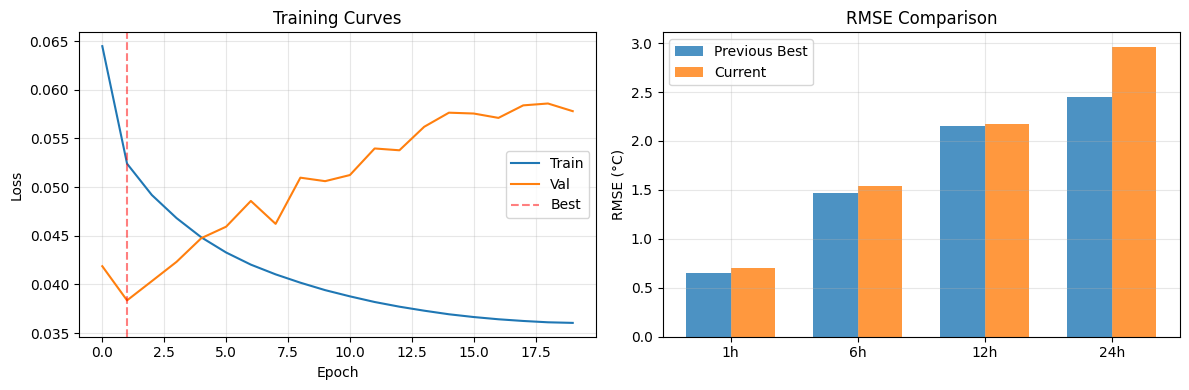

Done!


In [32]:
# Visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

ax = axes[0]
ax.plot(history['train_loss'], label='Train')
ax.plot(history['val_loss'], label='Val')
ax.axvline(best_epoch - 1, color='r', linestyle='--', alpha=0.5, label='Best')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Training Curves')
ax.legend()
ax.grid(True, alpha=0.3)

ax = axes[1]
x = np.arange(len(HORIZONS))
width = 0.35
prev_rmse = [previous_best[h]['rmse'] for h in HORIZONS]
curr_rmse = [m['rmse'] for m in test_metrics]
ax.bar(x - width/2, prev_rmse, width, label='Previous Best', alpha=0.8)
ax.bar(x + width/2, curr_rmse, width, label='Current', alpha=0.8)
ax.set_xticks(x)
ax.set_xticklabels([f'{h}h' for h in HORIZONS])
ax.set_ylabel('RMSE (°C)')
ax.set_title('RMSE Comparison')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(RESULTS_DIR / "figures" / "advanced_gnn_results.png", dpi=150)
plt.show()

print("Done!")